## Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import TumorDecon as td
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

## Data

In [2]:
lm22 = pd.read_csv("../data/LM22_source_GEPs.txt",delimiter="\t",index_col="genesinput")
lm22.shape

(11845, 22)

In [3]:
lm22_small = pd.read_csv("../data/LM22.txt",delimiter="\t",index_col="Gene symbol")
lm22_small.head()

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
Gene symbol,,,,,,,,,,,,,,,,,,,,,
ABCB4,555.713449,10.744235,7.225819,4.311280,4.605860,7.406442,8.043976,6.469993,7.833082,9.312295,...,6.202496,7.951360,27.557710,121.432277,114.636747,4.872184,4.727985,34.113659,15.030530,14.906888
ABCB9,15.603544,22.094787,653.392328,24.223723,35.671507,30.048192,38.455423,17.604795,46.073657,19.715722,...,20.309426,56.251887,29.380878,40.390260,123.993305,23.384603,53.466757,23.615746,29.786442,33.679147
ACAP1,215.305951,321.621021,38.616872,1055.613378,1790.097170,922.152747,340.883424,1107.798265,1995.482601,280.075719,...,190.879024,48.972217,30.974254,23.055150,61.386550,26.412923,104.200198,73.607932,696.442802,596.025961
ACHE,15.117949,16.648847,22.123737,13.428288,27.187732,18.444927,13.441268,14.805542,24.652712,33.658448,...,16.375268,13.692963,1373.069620,48.585761,16.715474,193.159977,13.948778,20.501249,40.414927,22.766494
ACP5,605.897384,1935.201479,1120.104684,306.312519,744.656599,557.819820,248.546932,711.949744,958.916018,493.969120,...,512.931382,13644.172300,1062.475909,7633.960182,13825.053630,3989.865169,263.497930,323.381277,860.563374,307.142798


In [4]:
def generate_samples(num_samples, lm22, max_dropout=.2):
    generated_x = np.zeros((num_samples,11845))
    generated_y = np.zeros((num_samples,22))
    lm22_values = lm22.values
    number_of_each_cell = np.random.randint(0,15,size=(num_samples, 22))
    
    for i in range(num_samples):
        generated_x[i] = np.sum(lm22_values*number_of_each_cell[i], axis=1)
        indices = np.random.choice(np.arange(11845), replace=False,
                           size=int(11845 * np.random.uniform(max_dropout)))
        generated_x[i][indices] = 0
        generated_y[i] = number_of_each_cell[i]/np.sum(number_of_each_cell[i])
    
    
    t = td.df_normalization(pd.DataFrame(data=generated_x),"minmax")
    g_min = generated_x.min(axis=1)
    generated_x =(generated_x.T - g_min) / (generated_x.max(axis=1) - g_min)
    return generated_x.T, generated_y
    
def format_input(expression_df, lm22):
    return

In [5]:
m = tf.keras.Sequential()
m.add(tf.keras.layers.Dense(1024,  activation='elu', input_shape=(11845,)))
m.add(tf.keras.layers.Dense(512,  activation='elu'))
m.add(tf.keras.layers.Dense(256,  activation='elu'))
m.add(tf.keras.layers.Dense(128,    activation='linear', name="bottleneck"))
m.add(tf.keras.layers.Dense(256,  activation='elu'))
m.add(tf.keras.layers.Dense(512,  activation='elu'))
m.add(tf.keras.layers.Dense(1024,  activation='elu'))
m.add(tf.keras.layers.Dense(11845,  activation='sigmoid'))
m.compile(loss='mean_squared_error', optimizer = tf.keras.optimizers.Adam(),metrics=['mse'])


m2 = tf.keras.Sequential()
m2.add(tf.keras.layers.Dense(512,  activation='elu', input_shape=(11845,)))
m2.add(tf.keras.layers.Dense(512,  activation='elu'))
m2.add(tf.keras.layers.Dense(22,    activation='linear'))
m2.compile(loss='mean_squared_error', optimizer = tf.keras.optimizers.Adam(),metrics=['mse'])

In [6]:
X,Y = generate_samples(50000,lm22,max_dropout=0.2)

In [7]:
#td.cell_frequency_barchart(pd.DataFrame(data=Y,columns=lm22_small.columns))

## Models
The generated data looks pretty good so now I am going to move onto modeling and making an auto encoder to reduce the dimensionality of the data. Then I will train a neural net totake in the reduced vector and predict immune cell fractions

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [9]:
X_train.shape

(45000, 11845)

In [10]:
history = m.fit(X_train, X_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test, X_test))

encoder = tf.keras.Model(m.input, m.get_layer('bottleneck').output)
Zenc = encoder.predict(X_train)  # bottleneck representation
Renc = m.predict(X_train)        # reconstruction

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 12s 272us/sample - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 2/10
45000/45000 [==============================] - 11s 237us/sample - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 3/10
45000/45000 [==============================] - 11s 238us/sample - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 4/10
45000/45000 [==============================] - 11s 239us/sample - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 5/10
45000/45000 [==============================] - 11s 238us/sample - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 6/10
45000/45000 [==============================] - 11s 238us/sample - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 7/10
45000/45000 [==============================] - 11s 237us/sample - loss: 0.0012 - mse: 0.0012 -

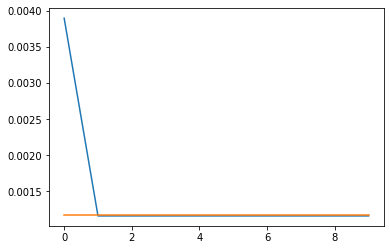

In [11]:
plt.plot(history.history['mse'], label='root_mean_squared_error')    #blue
plt.plot(history.history['val_mse'], label = 'val_root_mean_squared_error') 

In [12]:
history = m2.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_data=(X_test, y_test))

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 5s 115us/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 5.9745e-04 - val_mse: 5.9745e-04
Epoch 2/20
45000/45000 [==============================] - 5s 101us/sample - loss: 5.3650e-04 - mse: 5.3650e-04 - val_loss: 5.4391e-04 - val_mse: 5.4391e-04
Epoch 3/20
45000/45000 [==============================] - 5s 102us/sample - loss: 4.4832e-04 - mse: 4.4832e-04 - val_loss: 4.5782e-04 - val_mse: 4.5782e-04
Epoch 4/20
45000/45000 [==============================] - 5s 102us/sample - loss: 4.0380e-04 - mse: 4.0380e-04 - val_loss: 4.5403e-04 - val_mse: 4.5403e-04
Epoch 5/20
45000/45000 [==============================] - 5s 102us/sample - loss: 3.7733e-04 - mse: 3.7733e-04 - val_loss: 3.9761e-04 - val_mse: 3.9761e-04
Epoch 6/20
45000/45000 [==============================] - 5s 102us/sample - loss: 3.6707e-04 - mse: 3.6707e-04 - val_loss: 4.1748e-04 - val_mse: 4.1748e-04
Epoch 7/20
45000/45000 

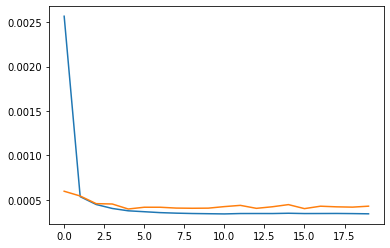

In [13]:
plt.plot(history.history['mse'], label='root_mean_squared_error')    #blue
plt.plot(history.history['val_mse'], label = 'val_root_mean_squared_error') 

In [14]:
to_compare = m2.predict(X_test[:50])
nn_results_df = pd.DataFrame(data=to_compare,columns=lm22_small.columns)

In [15]:
test_df = pd.DataFrame(data=X_test[:50],columns=lm22.index)
cibersort_results = td.cibersort_main(test_df.T,lm22_small).fillna(0)

Running CiberSort...


In [16]:
test_df.head()

genesinput,A1CF,A2M,A4GALT,A4GNT,AAAS,AACS,AADAC,AAGAB,AAK1,AAMP,...,ZSCAN5A,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,0.007905,0.000000,0.0,0.006512,0.002235,0.012093,0.000000,0.000000,0.000000,0.019886,...,0.008564,0.026746,0.005460,0.0,0.0,0.002490,0.0,0.000000,0.012451,0.019494
2,0.009383,0.067404,0.0,0.007639,0.003047,0.000000,0.001337,0.007054,0.004572,0.000000,...,0.009119,0.000000,0.007262,0.0,0.0,0.003078,0.0,0.064911,0.014155,0.020996
3,0.000000,0.000000,0.0,0.000000,0.000000,0.042415,0.000000,0.000000,0.000000,0.000000,...,0.026458,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.011734,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000


## Comparting Predictions

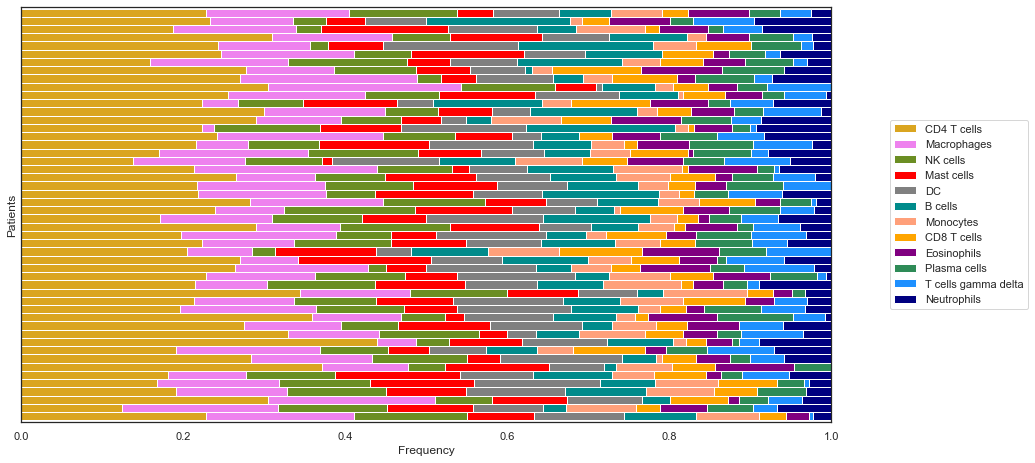

In [17]:
td.cell_frequency_barchart(pd.DataFrame(data=Y[:50],columns=lm22_small.columns))

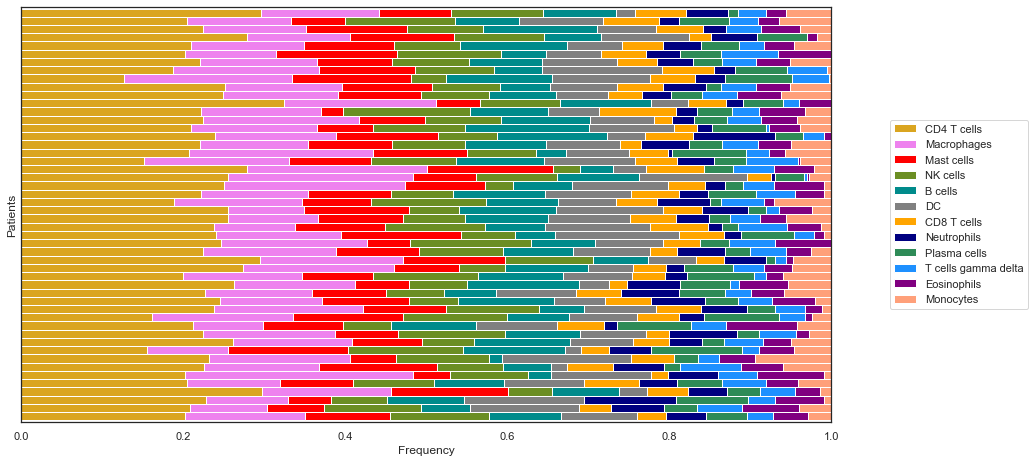

In [18]:
td.cell_frequency_barchart(nn_results_df)

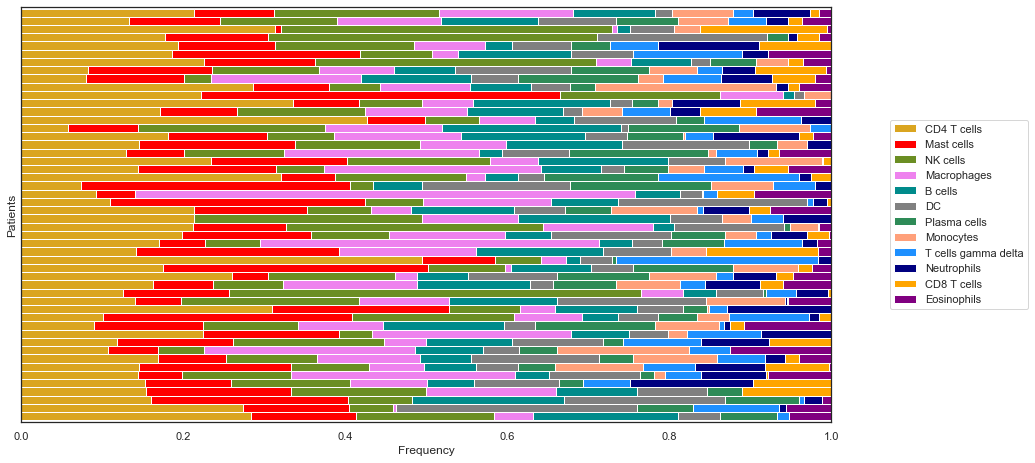

In [19]:
td.cell_frequency_barchart(cibersort_results)

In [20]:
nn_comb = td.combine_celltypes(nn_results_df)
c_comb = td.combine_celltypes(cibersort_results).fillna(0)
y_comb = td.combine_celltypes(pd.DataFrame(data=Y[:50],columns=lm22_small.columns))

0.7518436972072909

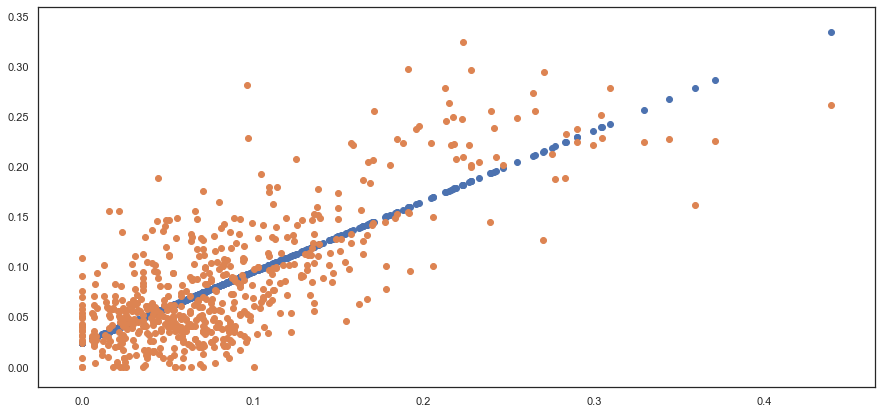

In [21]:
lin = LinearRegression().fit(y_comb.values.flatten().reshape(-1, 1),nn_comb.values.flatten().reshape(-1, 1))
plt.scatter(y_comb.values.flatten().reshape(-1, 1),lin.predict(y_comb.values.flatten().reshape(-1, 1)))
plt.scatter(y_comb.values,nn_comb.values)
lin.score(y_comb.values.flatten().reshape(-1, 1),nn_comb.values.flatten().reshape(-1, 1))**.5

0.4482774733443991

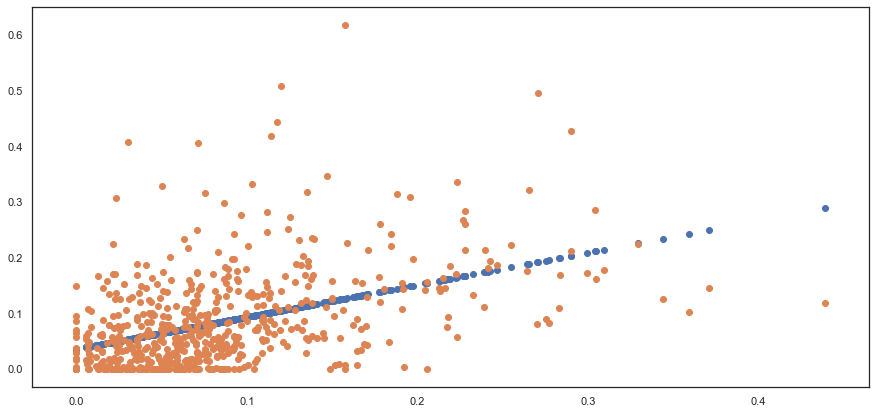

In [22]:
lin = LinearRegression().fit(y_comb.values.flatten().reshape(-1, 1),c_comb.values.flatten().reshape(-1, 1))
plt.scatter(y_comb.values.flatten().reshape(-1, 1),lin.predict(y_comb.values.flatten().reshape(-1, 1)))
plt.scatter(y_comb.values,c_comb.values)
lin.score(y_comb.values.flatten().reshape(-1, 1),c_comb.values.flatten().reshape(-1, 1))**.5

In [23]:
print("NN MAE:",mean_absolute_error(y_comb.values,nn_comb.values))
print("CIBERSORT MAE:",mean_absolute_error(y_comb.values,c_comb.values))

NN MAE: 0.03570545484369756
CIBERSORT MAE: 0.058555603092935275


## Bring in Other Test Data

In [84]:
cibersort_gep = pd.read_csv("C:/Users/NathanGrant/Programs/TripodsREU/data/ExampleMixtures-GEPs.txt",delimiter="\t",index_col="Hugo_Symbol")
cibersort_gep.index.name = "genesinput"
cibersort_gep.head()

,Mix1,Mix2,Mix3,Mix4,Mix5
genesinput,,,,,
A1CF,317.722091,293.341077,217.299844,324.780988,249.629992
A2M,151.455508,530.830854,837.158282,692.726721,2510.675378
A4GALT,73.512724,92.717987,64.725953,71.602486,81.679389
A4GNT,288.295490,259.639816,158.096971,282.407327,197.121171
AAAS,108.864797,106.834378,103.505401,50.651212,65.309679


In [106]:
cibersort_truth = pd.read_csv("C:/Users/NathanGrant/Programs/TripodsREU/data/ExampleMixtures-GroundTruth.txt",delimiter="\t")
cibersort_truth.columns = lm22_small.columns
cibersort_truth.head()

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
0,0.18,0.16,0.13,0.11,0.09,0.07,0.06,0.05,0.04,0.03,...,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00
1,0.20,0.00,0.19,0.00,0.18,0.00,0.10,0.00,0.09,0.00,...,0.05,0.00,0.04,0.00,0.04,0.00,0.02,0.00,0.02,0.00
2,0.00,0.00,0.01,0.01,0.01,0.02,0.03,0.05,0.07,0.11,...,0.11,0.07,0.05,0.03,0.02,0.01,0.01,0.01,0.00,0.00
3,0.17,0.12,0.08,0.06,0.03,0.02,0.01,0.00,0.00,0.00,...,0.00,0.00,0.00,0.01,0.02,0.03,0.06,0.08,0.12,0.17
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.03,0.04,...,0.02,0.04,0.09,0.11,0.08,0.05,0.04,0.07,0.14,0.20


In [90]:
lm22.T.head()

genesinput,A1CF,A2M,A4GALT,A4GNT,AAAS,AACS,AADAC,AAGAB,AAK1,AAMP,...,ZSCAN5A,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
B cells naive,444.697134,20.303593,33.212550,381.468767,18.375534,234.767226,54.982722,36.587171,133.845450,785.226264,...,618.750693,2505.072467,34.488729,785.907083,83.495313,153.851062,56.249196,512.873831,146.841228,519.420730
B cells memory,499.621456,23.559923,42.983330,499.399737,21.251780,251.068231,76.489893,46.495668,125.976707,1016.836195,...,426.149348,1991.102583,39.162552,1004.186179,90.271544,94.957767,41.225592,641.556952,259.027984,501.143497
Plasma cells,317.348613,45.836411,127.584987,289.693270,70.266151,691.357992,33.538210,42.961361,192.888217,1258.260720,...,305.302004,1264.736695,132.923739,535.375457,97.090451,104.211251,30.533496,635.943077,326.776069,521.910283
T cells CD8,267.475035,21.880510,44.990740,201.294509,169.849984,384.900206,23.365501,293.745987,159.400761,524.070942,...,182.465549,729.156318,197.949608,291.575512,135.179940,80.056476,295.125513,1518.436823,457.165990,761.114362
T cells CD4 naive,215.012469,18.571284,142.182291,219.494712,169.843772,404.673281,24.485187,220.108732,108.993570,447.085391,...,81.202364,393.915251,296.506015,365.612262,227.598349,92.357356,486.174743,1052.262476,406.210896,701.541609


In [107]:
cibersort_gep = cibersort_gep.merge(lm22, how="right",on="genesinput").fillna(0)
cibersort_gep = cibersort_gep.loc[lm22.index,["Mix1","Mix2",'Mix3',"Mix4","Mix5"]]

In [108]:
to_compare = m2.predict(cibersort_gep.T.values)
nn_results_df = pd.DataFrame(data=to_compare,columns=lm22_small.columns)
test_df = pd.DataFrame(data=cibersort_gep.T.values,columns=lm22.index)
cibersort_results = td.cibersort_main(test_df.T,lm22_small).fillna(0)

Running CiberSort...


In [109]:
nn_comb = td.combine_celltypes(nn_results_df)
c_comb = td.combine_celltypes(cibersort_results).fillna(0)
y_comb = td.combine_celltypes(cibersort_truth)

In [110]:
cibersort_gep.head()

,Mix1,Mix2,Mix3,Mix4,Mix5
genesinput,,,,,
A1CF,317.722091,293.341077,217.299844,324.780988,249.629992
A2M,151.455508,530.830854,837.158282,692.726721,2510.675378
A4GALT,73.512724,92.717987,64.725953,71.602486,81.679389
A4GNT,288.295490,259.639816,158.096971,282.407327,197.121171
AAAS,108.864797,106.834378,103.505401,50.651212,65.309679


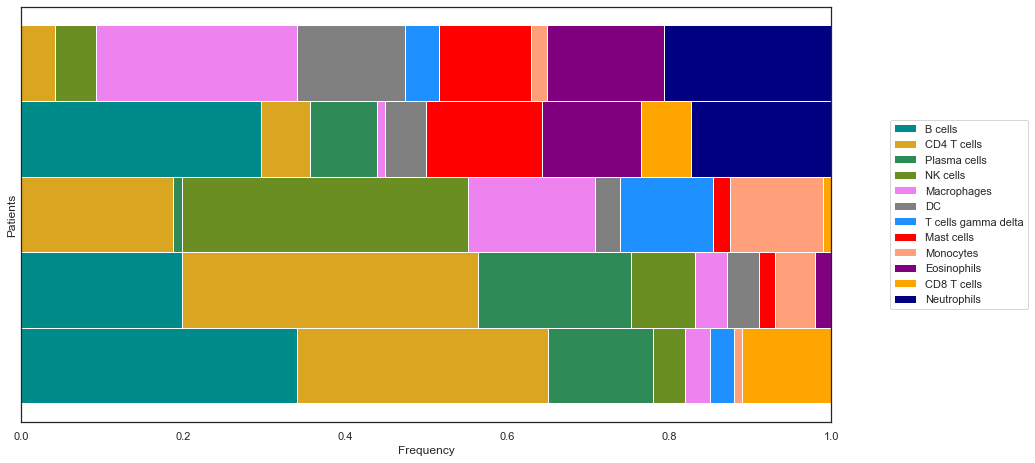

In [111]:
td.cell_frequency_barchart(cibersort_truth)

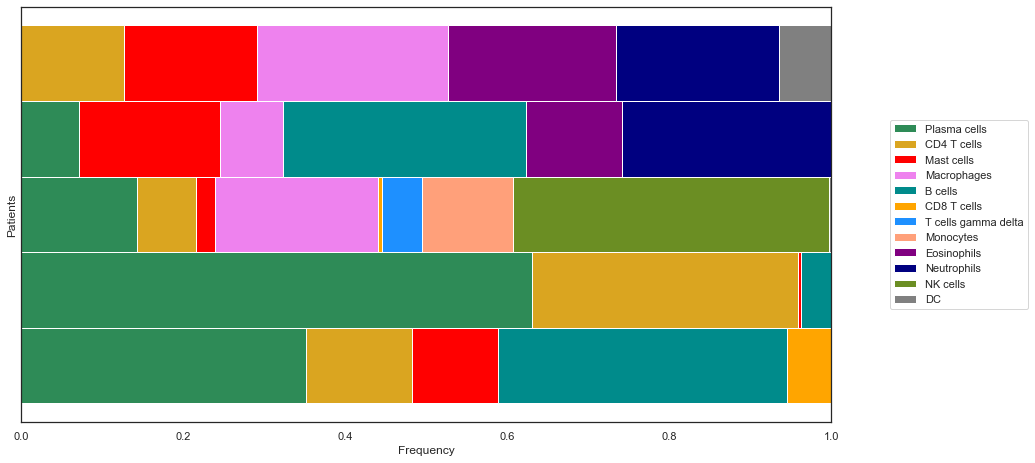

In [112]:
td.cell_frequency_barchart(nn_results_df)

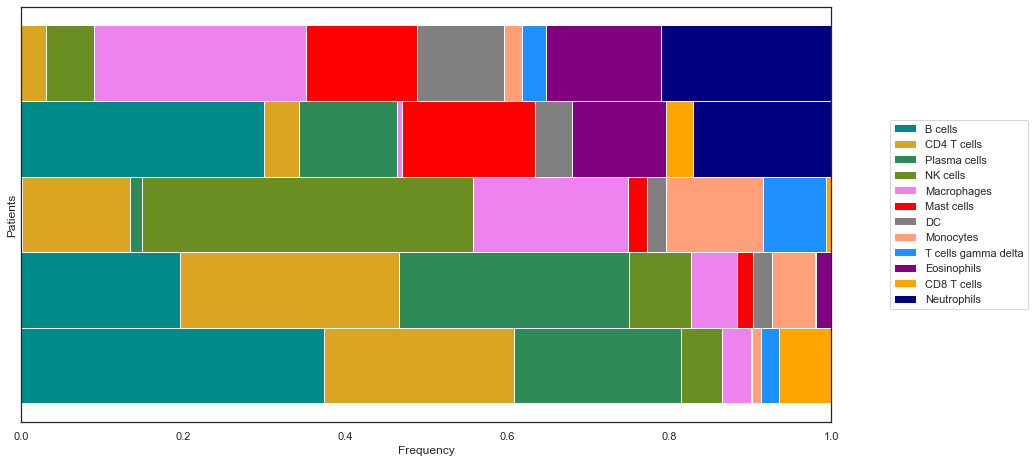

In [115]:
td.cell_frequency_barchart(cibersort_results)

0.762474647309362

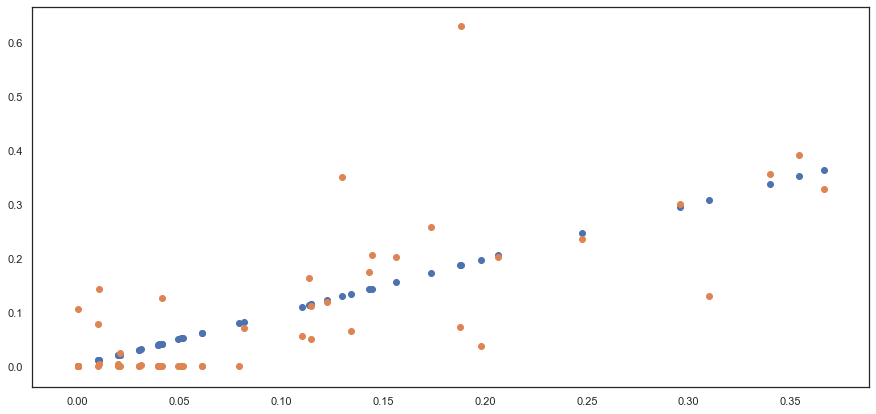

In [113]:
lin = LinearRegression().fit(y_comb.values.flatten().reshape(-1, 1),nn_comb.values.flatten().reshape(-1, 1))
plt.scatter(y_comb.values.flatten().reshape(-1, 1),lin.predict(y_comb.values.flatten().reshape(-1, 1)))
plt.scatter(y_comb.values,nn_comb.values)
lin.score(y_comb.values.flatten().reshape(-1, 1),nn_comb.values.flatten().reshape(-1, 1))**.5

0.9615043688731204

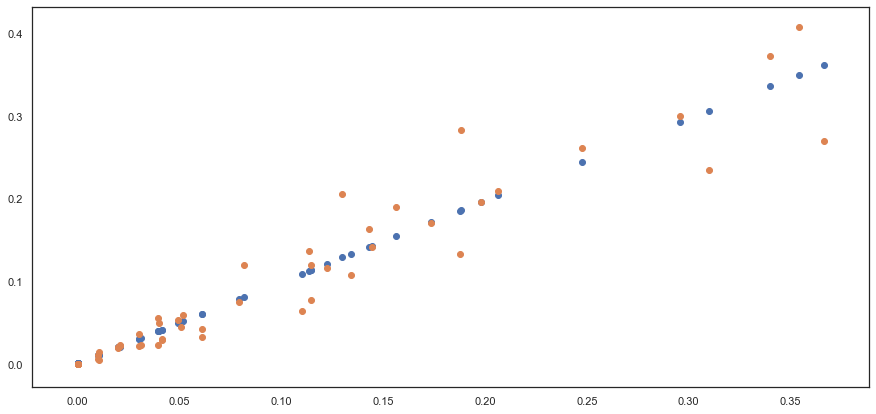

In [114]:
lin = LinearRegression().fit(y_comb.values.flatten().reshape(-1, 1),c_comb.values.flatten().reshape(-1, 1))
plt.scatter(y_comb.values.flatten().reshape(-1, 1),lin.predict(y_comb.values.flatten().reshape(-1, 1)))
plt.scatter(y_comb.values,c_comb.values)
lin.score(y_comb.values.flatten().reshape(-1, 1),c_comb.values.flatten().reshape(-1, 1))**.5

In [116]:
print("NN MAE:",mean_absolute_error(y_comb.values,nn_comb.values))
print("CIBERSORT MAE:",mean_absolute_error(y_comb.values,c_comb.values))

NN MAE: 0.046335366967303566
CIBERSORT MAE: 0.015538388329207032
